# Compare differences between 50 m and 100 m model runs in East River Watershed
*J. Michelle Hu  
University of Utah  
May 2024*  
---

In [1]:
import sys
import xarray as xr
import numpy as np

from pathlib import PurePath
import pandas as pd
import hvplot.xarray
import rioxarray as riox
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')

import helpers as h

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/work/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


### What impact does 50 m resolution vs. 100 m resolution run have on:  
- snow depth spatial distributions?
- snow depth temporal meltout?
- cumulative (i.e., basinwide) values?

### Load up snow files

In [2]:
# Working directories of outputs for WY 2018
wd_2018_50m = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_newbasin_isnobal/wy2018/erw_newbasin'
wd_2018_100m = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_100m_isnobal/wy2018/erw_newbasin_100m'
snow50_fns = h.fn_list(wd_2018_50m, '*/snow.nc')
snow100_fns = h.fn_list(wd_2018_100m, '*/snow.nc')
print(len(snow50_fns), len(snow100_fns))

365 365


In [3]:
# Read in snow.nc to start
ds = xr.open_dataset(snow50_fns[100])
ds

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 1, y: 837, x: 656)
Coordinates:
  * time              (time) datetime64[ns] 8B 2018-01-09T22:00:00
  * y                 (y) float32 3kB 4.323e+06 4.323e+06 ... 4.281e+06
  * x                 (x) float32 3kB 3.159e+05 3.16e+05 ... 3.486e+05 3.487e+05
Data variables:
    thickness         (time, y, x) float32 2MB ...
    snow_density      (time, y, x) float32 2MB ...
    specific_mass     (time, y, x) float32 2MB ...
    liquid_water      (time, y, x) float32 2MB ...
    temp_surf         (time, y, x) float32 2MB ...
    temp_lower        (time, y, x) float32 2MB ...
    temp_snowcover    (time, y, x) float32 2MB ...
    thickness_lower   (time, y, x) float32 2MB ...
    water_saturation  (time, y, x) float32 2MB ...
    projection        |S1 1B ...

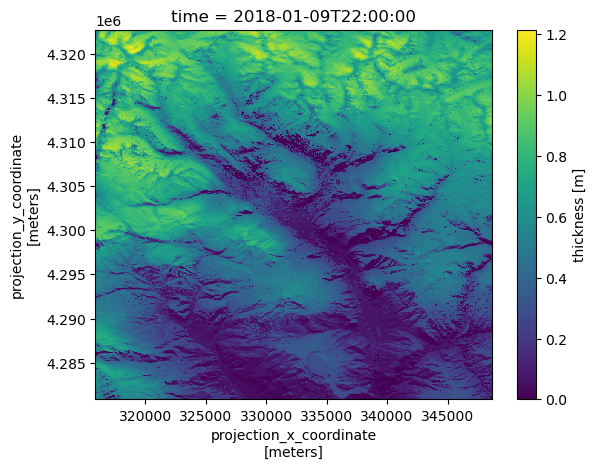

In [4]:
ds['thickness'].plot()

In [5]:
import pathlib as p

In [6]:
def get_varnc(basin=None, indir=None, indate=None, templatefn=None, returnvar=None):
    '''Returns specified output files based on template file or basin and date.
    If no specified variable, returns all files
    basin = erw_newbasin_isnobal/
    indir = erw_newbasin_isnobal/wy2018/erw_newbasin/
    indate = 20180109
    TODO
    maybe remove basin
    add returnvar handling for an input list

    '''
    import pathlib as p
        
    # first check if you are looking for specific date based on template fn    
    if templatefn is not None:
        datedir = p.PurePath(templatefn).parent.as_posix()

    # or an input directory and specific date    
    elif (indir is not None) & (indate is not None):
        datedir = h.fn_list(indir, f'*{indate}/')[0]

    if returnvar is None:
        return h.fn_list(datedir, '*nc')
    else:
        return h.fn_list(datedir, f'{returnvar}.nc')

In [7]:
get_varnc(templatefn=snow50_fns[100])

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_newbasin_isnobal/wy2018/erw_newbasin/run20180109/air_temp.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_newbasin_isnobal/wy2018/erw_newbasin/run20180109/albedo_ir.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_newbasin_isnobal/wy2018/erw_newbasin/run20180109/albedo_vis.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_newbasin_isnobal/wy2018/erw_newbasin/run20180109/cloud_factor.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_newbasin_isnobal/wy2018/erw_newbasin/run20180109/em.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_newbasin_isnobal/wy2018/erw_newbasin/run20180109/net_solar.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_newbasin_isnobal/wy2018/erw_newbasin/run20180109/percent_snow.nc',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/test/erw_newbasin_isnobal/wy2018/erw_newbasin/run20180109/precip.n

### Direct comparisons
- plot 50 m, 100 m, and spatial diff
- store those spatial diffs as arrays and plot boxplots of each day for this WY as narrow lines

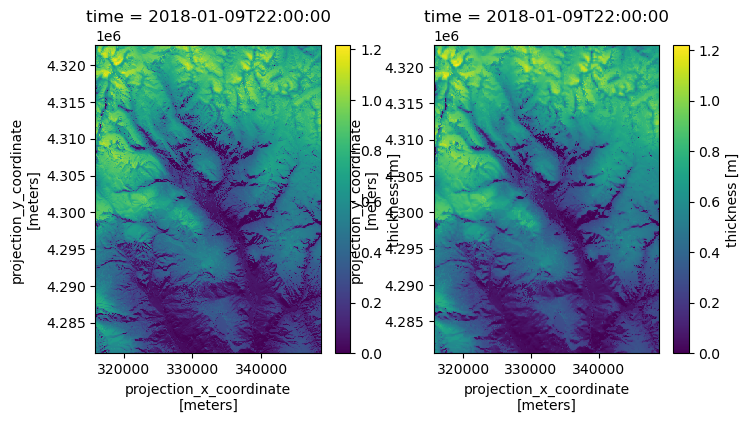

In [8]:
indate = '20180109'
snow_50_ds = xr.open_dataset(get_varnc(indir=wd_2018_50m, indate=indate, returnvar='snow')[0])
snow_100_ds = xr.open_dataset(get_varnc(indir=wd_2018_100m, indate=indate, returnvar='snow')[0])
fig, axa = plt.subplots(1, 2, figsize=(8, 4))
snow_50_ds['thickness'].plot(ax=axa[0])
snow_100_ds['thickness'].plot(ax=axa[1])

In [9]:
def extract_ravel_varvals(ds, varname='thickness'):
    '''Extract variable values from input DataArray, default snow depth (thickness)'''
    return np.ravel(ds[varname].values)

In [10]:
def extract_boxplot_vals(rav_arr):
    '''Extract outlier thresholds, 25th p, 50th p, and 75th p
    Returns: lowwhisk, p25, p50, p75, highwhisk
    TODO: consider using robust thresholds for this
    '''
    
    p25 = np.nanpercentile(rav_arr, 25) # first quartile
    p50 = np.nanmedian(rav_arr)
    p75 = np.nanpercentile(rav_arr, 75) # third quartile
    iqr = p75 - p25
    
    # Compute outlier thresholds
    lowwhisk = p25 - 1.5 * iqr
    highwhisk = p75 + 1.5 * iqr
    
    return lowwhisk, p25, p50, p75, highwhisk

In [11]:
# Test the function
boxvals = extract_boxplot_vals(extract_ravel_varvals(snow_50_ds))
boxvals

(-0.48056628182530403,
 0.23504400998353958,
 0.47775227,
 0.712117537856102,
 1.4277278296649456)

In [12]:
def fn2boxval(fn, varname='thickness'):
    '''from snow.nc filename to boxplot values of specified variable value'''
    ds = xr.open_dataset(fn)
    raveled_vals = extract_ravel_varvals(ds, varname=varname)
    boxvals = extract_boxplot_vals(raveled_vals)
    
    return boxvals

In [13]:
%%time
boxvals_50 = []
boxvals_100 = []
for fn50, fn100 in zip(snow50_fns, snow100_fns):
    bval50 = fn2boxval(fn50)
    bval100 = fn2boxval(fn100)
    
    boxvals_50.append(bval50)
    boxvals_100.append(bval100)

CPU times: user 32 s, sys: 4.19 s, total: 36.2 s
Wall time: 1min 34s


In [14]:
# Create dataframe of boxplot values for easier plotting
df_50 = pd.DataFrame(data=np.transpose(boxvals_50))
df_100 = pd.DataFrame(data=np.transpose(boxvals_100))
df_50

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,0.0,-0.010649,-0.00675,0.0,0.0,0.0,0.0,0.0,-0.102072,-0.105414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.054692,0.015726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.096664,0.045363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.007099,0.00450,0.0,0.0,0.0,0.0,0.0,0.159201,0.096487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.017748,0.01125,0.0,0.0,0.0,0.0,0.0,0.315965,0.217627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CPU times: user 3.37 s, sys: 25.6 ms, total: 3.39 s
Wall time: 3.43 s


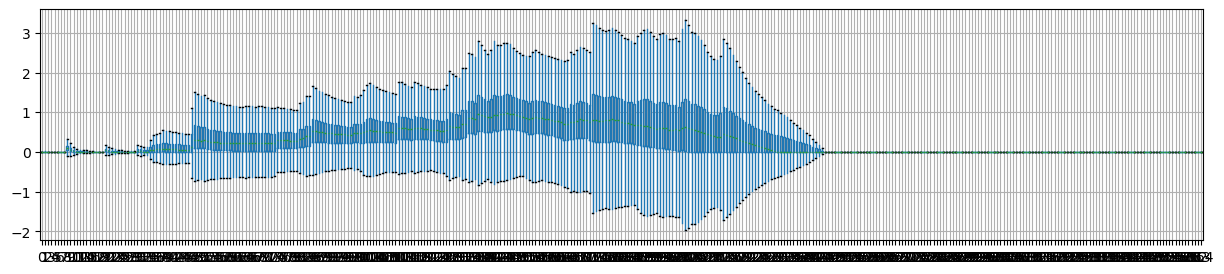

In [15]:
%%time
df_50.boxplot(figsize=(15,3));

CPU times: user 3.55 s, sys: 11.3 ms, total: 3.56 s
Wall time: 3.59 s


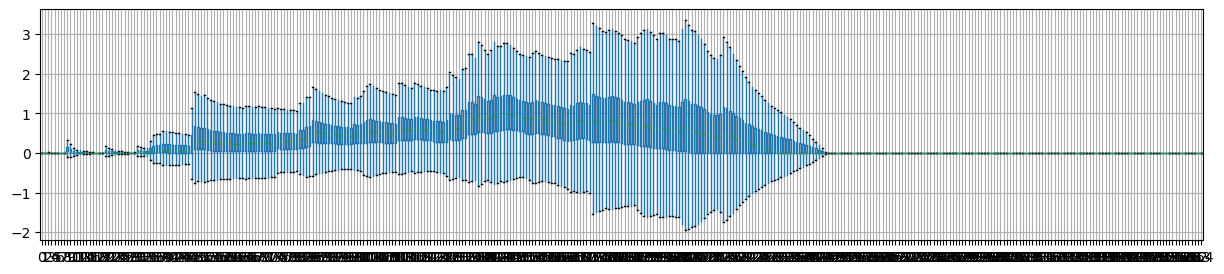

In [16]:
%%time
df_100.boxplot(figsize=(15,3));

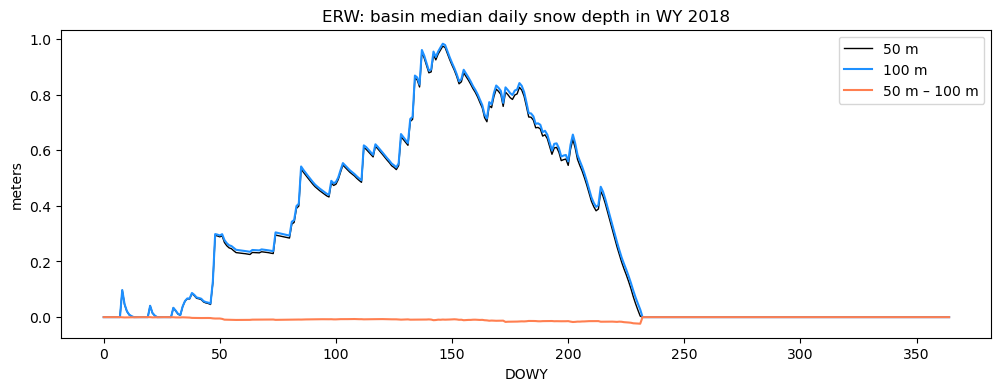

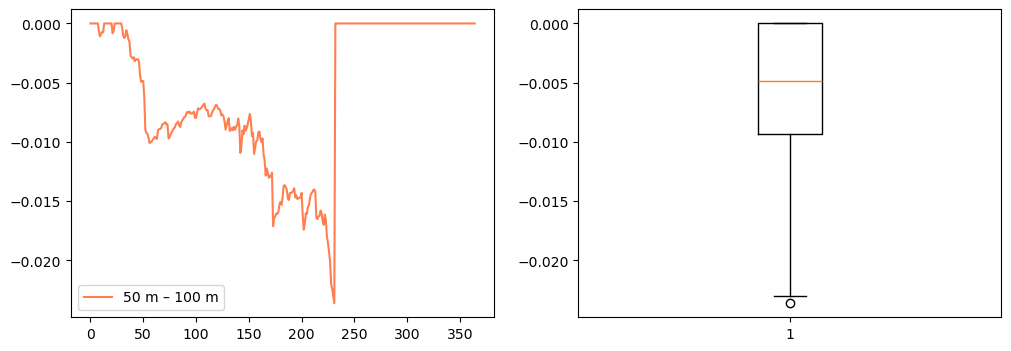

In [17]:
# Plot the medians only
fig, ax = plt.subplots(1, figsize=(12,4))
df_50.iloc[2].plot(ax=ax, label='50 m', c='k', linestyle='-', linewidth=1)
df_100.iloc[2].plot(ax=ax, label='100 m', c='dodgerblue')
(df_50.iloc[2] - df_100.iloc[2]).plot(ax=ax, label='50 m – 100 m', c='coral')
ax.set_xlabel('DOWY');
ax.set_ylabel('meters');
plt.title('ERW: basin median daily snow depth in WY 2018')
plt.legend();


fig, axa = plt.subplots(1, 2, figsize=(12,4))
ax = axa[0]
(df_50.iloc[2] - df_100.iloc[2]).plot(ax=ax, label='50 m – 100 m', c='coral')
ax.legend();
ax = axa[1]
ax.boxplot(df_50.iloc[2] - df_100.iloc[2]);

In [18]:
snow_50_ds.data_vars

Data variables:
    thickness         (time, y, x) float32 2MB 0.6696 0.7043 0.7458 ... 0.0 0.0
    snow_density      (time, y, x) float32 2MB ...
    specific_mass     (time, y, x) float32 2MB ...
    liquid_water      (time, y, x) float32 2MB ...
    temp_surf         (time, y, x) float32 2MB ...
    temp_lower        (time, y, x) float32 2MB ...
    temp_snowcover    (time, y, x) float32 2MB ...
    thickness_lower   (time, y, x) float32 2MB ...
    water_saturation  (time, y, x) float32 2MB ...
    projection        |S1 1B ...

### Now try it with snow density

In [19]:
%%time
boxvals_50 = []
boxvals_100 = []

varname='snow_density'

for fn50, fn100 in zip(snow50_fns, snow100_fns):
    bval50 = fn2boxval(fn50, varname=varname)
    bval100 = fn2boxval(fn100, varname=varname)
    
    boxvals_50.append(bval50)
    boxvals_100.append(bval100)

CPU times: user 32.4 s, sys: 4.18 s, total: 36.5 s
Wall time: 41.5 s


In [20]:
# Create dataframe of boxplot values for easier plotting
df_50 = pd.DataFrame(data=np.transpose(boxvals_50))
df_100 = pd.DataFrame(data=np.transpose(boxvals_100))
df_50

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,0.0,-214.368828,-198.960051,0.0,0.0,0.0,0.0,0.0,3.825281,-188.551351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,75.167738,97.301786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,98.862976,182.072403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,142.912552,132.640034,0.0,0.0,0.0,0.0,0.0,122.729376,287.870544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,357.281380,331.600084,0.0,0.0,0.0,0.0,0.0,194.071833,573.723681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CPU times: user 3.61 s, sys: 6.46 ms, total: 3.62 s
Wall time: 3.65 s


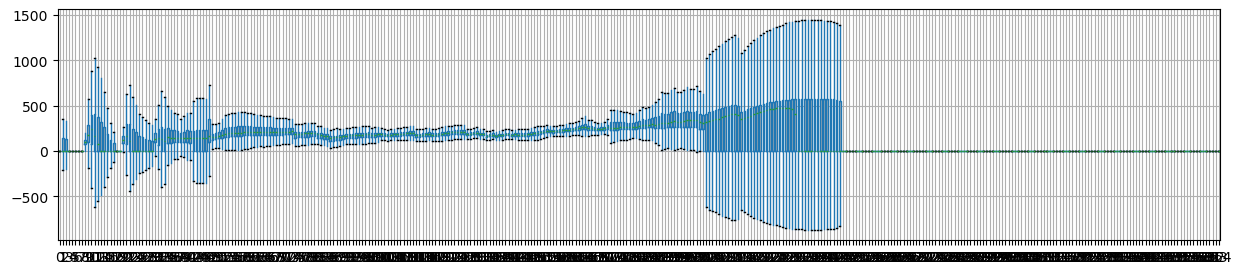

In [21]:
%%time
df_50.boxplot(figsize=(15,3));

CPU times: user 3.36 s, sys: 24.4 ms, total: 3.38 s
Wall time: 3.4 s


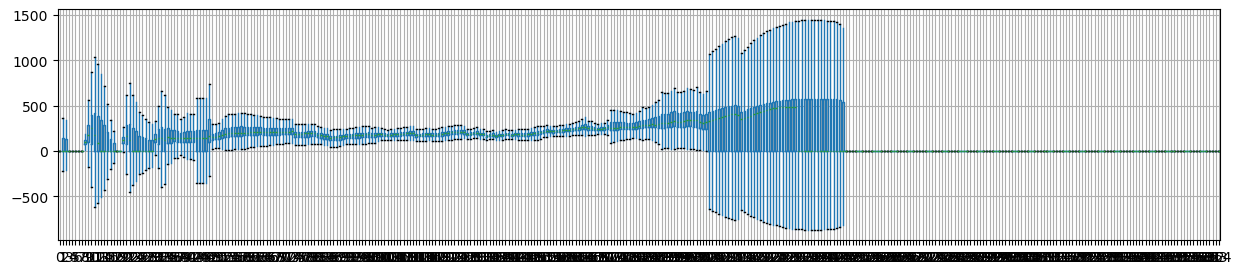

In [22]:
%%time
df_100.boxplot(figsize=(15,3));

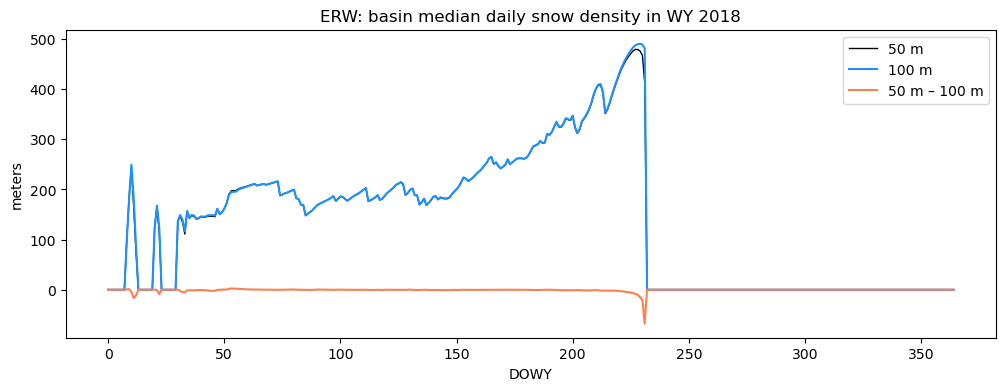

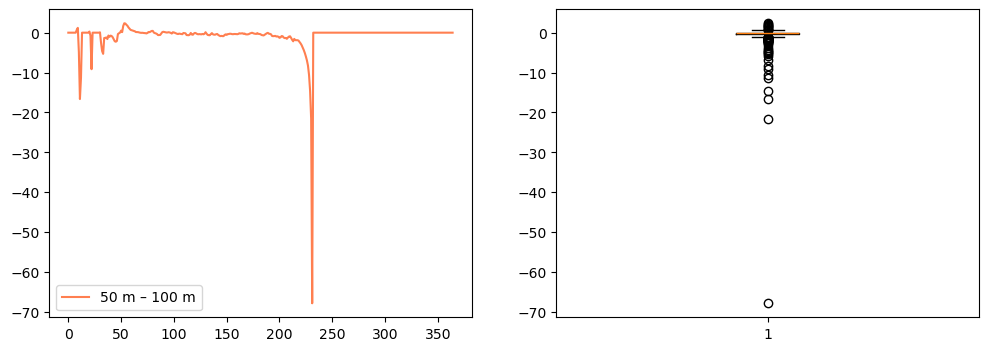

In [50]:
# Plot the medians only
fig, ax = plt.subplots(1, figsize=(12, 4))
df_50.iloc[2].plot(ax=ax, label='50 m', c='k', linestyle='-', linewidth=1)
df_100.iloc[2].plot(ax=ax, label='100 m', c='dodgerblue')
(df_50.iloc[2] - df_100.iloc[2]).plot(ax=ax, label='50 m – 100 m', c='coral')
ax.set_xlabel('DOWY');
ax.set_ylabel('meters');
plt.title('ERW: basin median daily snow density in WY 2018')
plt.legend();


fig, axa = plt.subplots(1, 2, figsize=(12, 4))
ax = axa[0]
(df_50.iloc[2] - df_100.iloc[2]).plot(ax=ax, label='50 m – 100 m', c='coral')
ax.legend();
ax = axa[1]
ax.boxplot(df_50.iloc[2] - df_100.iloc[2]);

# ^^^ Steep drop-offs are around mid-may where we would anticipate greater impacts from coarser modeling outputs

## Plot side by side of mid may density

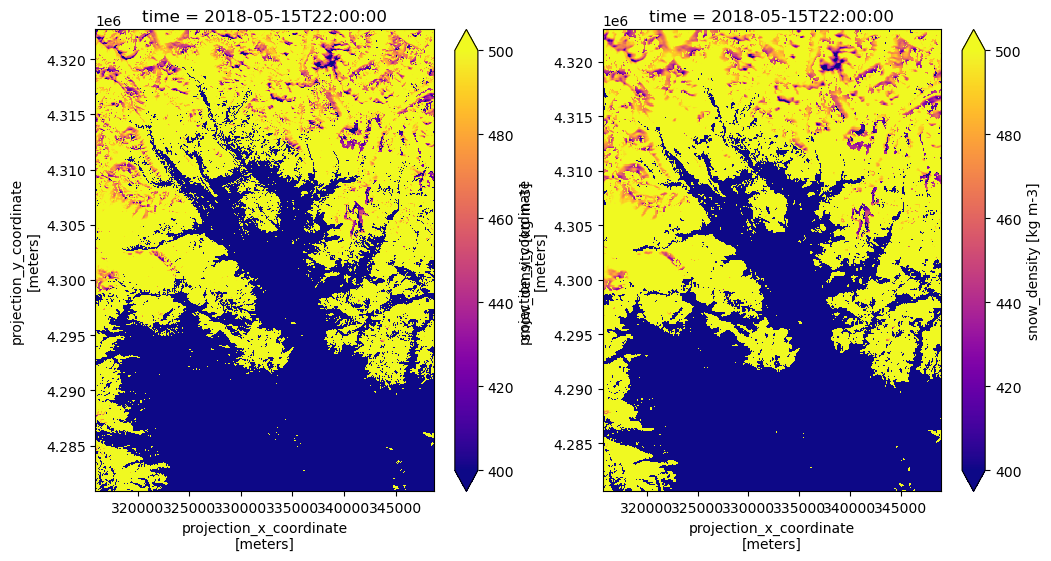

In [48]:
indate = '20180515'
vmin = 400
vmax = 500
cmap = 'plasma'
snow_50_ds = xr.open_dataset(get_varnc(indir=wd_2018_50m, indate=indate, returnvar='snow')[0])
snow_100_ds = xr.open_dataset(get_varnc(indir=wd_2018_100m, indate=indate, returnvar='snow')[0])
fig, axa = plt.subplots(1, 2, figsize=(12, 6))
snow_50_ds[varname].plot(ax=axa[0], vmin=vmin, vmax=vmax, cmap=cmap)
snow_100_ds[varname].plot(ax=axa[1], vmin=vmin, vmax=vmax, cmap=cmap)

#### And at the SNOTEL points

#### Do direct comparisons with ASO snow depth - need to handle proj for accessing all of the rasterio bits you'll need (reproject_match, clip_box, etc.)

In [51]:
aso_sd_fns = h.fn_list('/uufs/chpc.utah.edu/common/home/skiles-group1/ASO/CO', '*COGE_2018*.tif')
aso_sd_fns

['/uufs/chpc.utah.edu/common/home/skiles-group1/ASO/CO/ASO_50M_SD_USCOGE_20180331.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/ASO/CO/ASO_50M_SD_USCOGE_20180524.tif']

In [52]:
aso_sd_list = [h.load(fn) for fn in aso_sd_fns]
aso_sd_list

[<xarray.DataArray 'ASO_50M_SD_USCOGE_20180331' (y: 1033, x: 924)> Size: 4MB
 dask.array<getitem, shape=(1033, 924), dtype=float32, chunksize=(1033, 924), chunktype=numpy.ndarray>
 Coordinates:
   * x            (x) float64 7kB 3.052e+05 3.052e+05 ... 3.513e+05 3.513e+05
   * y            (y) float64 8kB 4.33e+06 4.33e+06 ... 4.279e+06 4.279e+06
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     Band_1:         ASO SUPER snow depth [m]
     scale_factor:   1.0
     add_offset:     0.0
     long_name:      ASO SUPER snow depth [m],
 <xarray.DataArray 'ASO_50M_SD_USCOGE_20180524' (y: 1033, x: 924)> Size: 4MB
 dask.array<getitem, shape=(1033, 924), dtype=float32, chunksize=(1033, 924), chunktype=numpy.ndarray>
 Coordinates:
   * x            (x) float64 7kB 3.052e+05 3.052e+05 ... 3.513e+05 3.513e+05
   * y            (y) float64 8kB 4.33e+06 4.33e+06 ... 4.279e+06 4.279e+06
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     Band_1:         ASO 

In [70]:
vmin, vmax = 0, 2

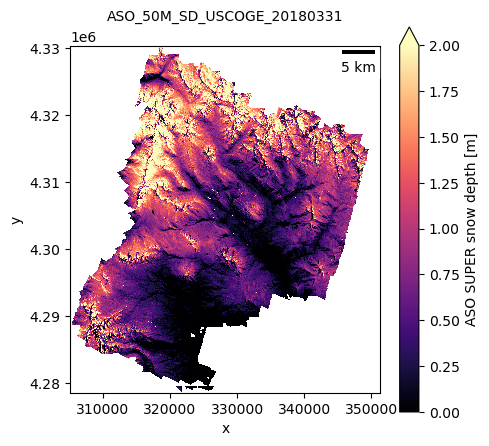

In [71]:
h.plot_one(aso_sd_list[0], figsize=(5, 5), title=aso_sd_list[0].name, vmin=vmin, vmax=vmax)

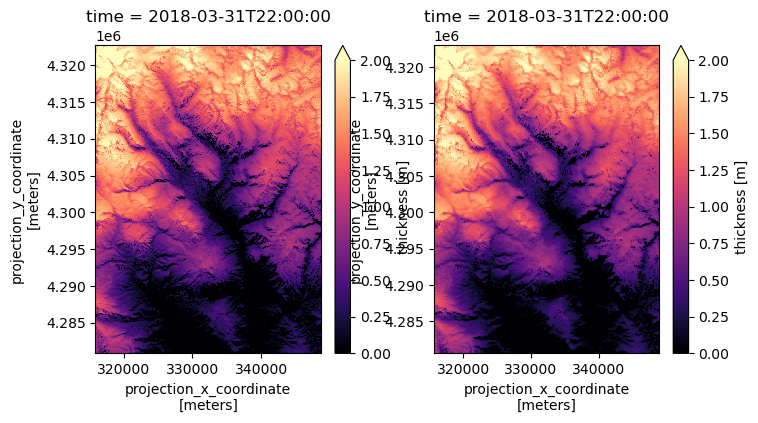

In [74]:
indate = '20180331'
cmap = 'magma'
snow_50_ds = xr.open_dataset(get_varnc(indir=wd_2018_50m, indate=indate, returnvar='snow')[0])
snow_100_ds = xr.open_dataset(get_varnc(indir=wd_2018_100m, indate=indate, returnvar='snow')[0])
fig, axa = plt.subplots(1, 2, figsize=(8, 4))
snow_50_ds['thickness'].plot(ax=axa[0], cmap=cmap, vmin=vmin, vmax=vmax)
snow_100_ds['thickness'].plot(ax=axa[1], cmap=cmap, vmin=vmin, vmax=vmax)

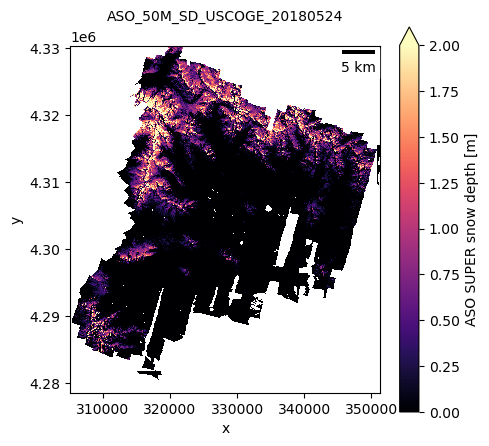

In [75]:
h.plot_one(aso_sd_list[1], figsize=(5, 5), title=aso_sd_list[1].name, vmin=vmin, vmax=vmax)

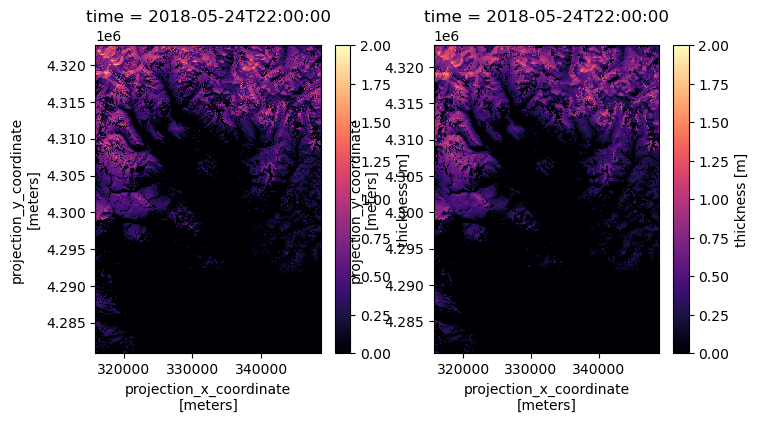

In [76]:
indate = '20180524'
snow_50_ds = xr.open_dataset(get_varnc(indir=wd_2018_50m, indate=indate, returnvar='snow')[0])
snow_100_ds = xr.open_dataset(get_varnc(indir=wd_2018_100m, indate=indate, returnvar='snow')[0])
fig, axa = plt.subplots(1, 2, figsize=(8, 4))
snow_50_ds['thickness'].plot(ax=axa[0], cmap=cmap, vmin=vmin, vmax=vmax)
snow_100_ds['thickness'].plot(ax=axa[1], cmap=cmap, vmin=vmin, vmax=vmax)